Before running the code blocks, run the following commands to get the kernel prepared:
```sh
julia
import Pkg
Pkg.update()
Pkg.precompile()

using Pkg
Pkg.build("IJulia")
```

In [23]:
using HDF5
using Serialization
using DataFrames, Plots, StatsPlots, CategoricalArrays, Statistics
using Plots.PlotMeasures 

In [57]:
function timer_dict_to_df(timer_dict)
    rows = []

    for (trial, ranks) in timer_dict
        n_important_prt, total_rank, nprt_per_rank, perm = split(trial, ":")
        n_important_prt = n_important_prt == "half" ? "50%" : n_important_prt
        trial_name = "$n_important_prt particles ($perm)"
        for (rank, timers) in ranks
            for (op, metrics) in timers["inner_timers"]
                for (metric, value) in metrics
                    if metric == "time_ns"
                        value = value / 1e3 # Convert nanoseconds to microseconds
                        metric = "time_micros"
                    end
                    push!(rows, (
                        trial  = String(trial_name),
                        perm = String(perm),
                        total_rank = parse(Int, total_rank),
                        nprt_per_rank = nprt_per_rank,
                        rank   = string(rank),
                        op     = String(op),
                        metric = String(metric),
                        value  = value,
                    ))
                end
            end
        end
    end
    return DataFrame(rows)
end

timer_dict_to_df (generic function with 1 method)

In [58]:
root = dirname(@__FILE__)
h5path(rank) = joinpath(root, "../test/output", "all_timers_$(rank).h5") 

# 1) read the raw byte‐blob from disk, automatically closing the file
all_timer_dfs = DataFrame()
for rank in [1, 2, 4, 8, 16]
    blob = h5open(h5path(rank)) do f
        read(f, "all_timers")
    end

    # 2) deserialize back into Dict{String,Dict{Int,Dict{String,Any}}}
    merged_timers = deserialize(IOBuffer(blob))

    # 3) convert to DataFrame
    timer_df = timer_dict_to_df(merged_timers)
    
    # 4) concat to all_timer_dfs
    all_timer_dfs = vcat(all_timer_dfs, timer_df)
end

# Sort by perm and trial
all_timer_dfs = sort!(all_timer_dfs, [:trial, :perm])


Row,trial,perm,total_rank,nprt_per_rank,rank,op,metric,value
,String,String,Int64,SubStrin…,String,String,String,Any
1,1 particles (firstperm),firstperm,1,1000,0,write from buffer,total_time_ns,0
2,1 particles (firstperm),firstperm,1,1000,0,write from buffer,total_allocated_bytes,0
3,1 particles (firstperm),firstperm,1,1000,0,write from buffer,time_micros,11767.5
4,1 particles (firstperm),firstperm,1,1000,0,write from buffer,n_calls,20
5,1 particles (firstperm),firstperm,1,1000,0,write from buffer,allocated_bytes,0
6,1 particles (firstperm),firstperm,1,1000,0,write from buffer,inner_timers,"Dict{String, Any}()"
7,1 particles (firstperm),firstperm,1,1000,0,receive loop,total_time_ns,0
8,1 particles (firstperm),firstperm,1,1000,0,receive loop,total_allocated_bytes,0
9,1 particles (firstperm),firstperm,1,1000,0,receive loop,time_micros,6976.25


In [59]:
# 1) Pivot wide
wide = unstack(
  all_timer_dfs,
  [:trial, :perm, :total_rank, :nprt_per_rank, :rank, :op],
  :metric,
  :value
)

# 2) Compute per‐call microseconds
wide.time_micros .= wide.time_micros ./ wide.n_calls
# first_perm = transform(
#     wide[wide.perm .== "firstperm", :],
#     :rank => ByRow(r -> r == "0" ? "0" : "other") => :rank
# )
# # 2) group on all of your original key-columns + the new rank
# g = groupby(
#     first_perm,
#     [:trial, :perm, :total_rank, :nprt_per_rank, :op, :rank]
# )
# # 3) average the per-call µs within each group, overwriting time_micros
# first_collapsed = combine(
#     g,
#     :time_micros => mean => :time_micros
# )

first_df = wide[wide.perm .== "firstperm", :]
rand_df = wide[wide.perm .== "randperm", :]

Row,trial,perm,total_rank,nprt_per_rank,rank,op,total_time_ns,total_allocated_bytes,time_micros,n_calls,allocated_bytes,inner_timers
,String,String,Int64,SubStrin…,String,String,Any,Any,Float64,Any,Any,Any
1,1 particles (randperm),randperm,1,1000,0,write from buffer,0,0,595.95,20,0,"Dict{String, Any}()"
2,1 particles (randperm),randperm,1,1000,0,receive loop,0,0,361.424,20,0,"Dict{String, Any}()"
3,1 particles (randperm),randperm,1,1000,0,waitall,0,0,0.14775,20,640,"Dict{String, Any}()"
4,1 particles (randperm),randperm,1,1000,0,send loop,0,0,2.6952,20,0,"Dict{String, Any}()"
5,1 particles (randperm),randperm,2,1000,0,write from buffer,0,0,670.212,20,0,"Dict{String, Any}()"
6,1 particles (randperm),randperm,2,1000,0,receive loop,0,0,117.557,20,2347296,"Dict{String, Any}()"
7,1 particles (randperm),randperm,2,1000,0,waitall,0,0,67052.3,20,82080,"Dict{String, Any}()"
8,1 particles (randperm),randperm,2,1000,0,send loop,0,0,23.7817,20,7680,"Dict{String, Any}()"
9,1 particles (randperm),randperm,2,1000,1,write from buffer,0,0,628.011,20,0,"Dict{String, Any}()"


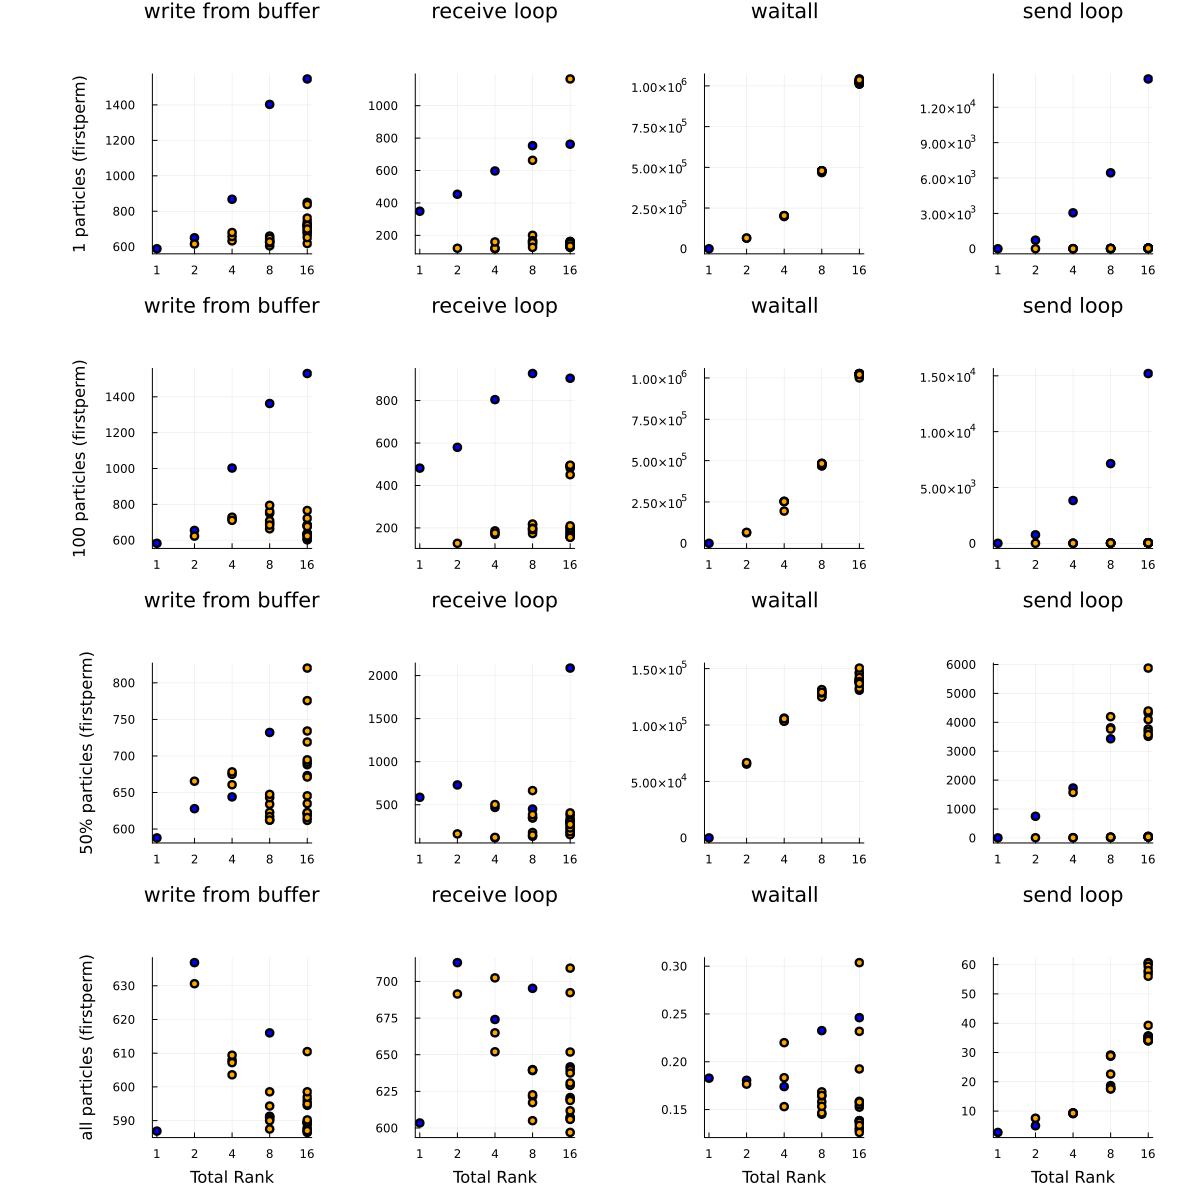

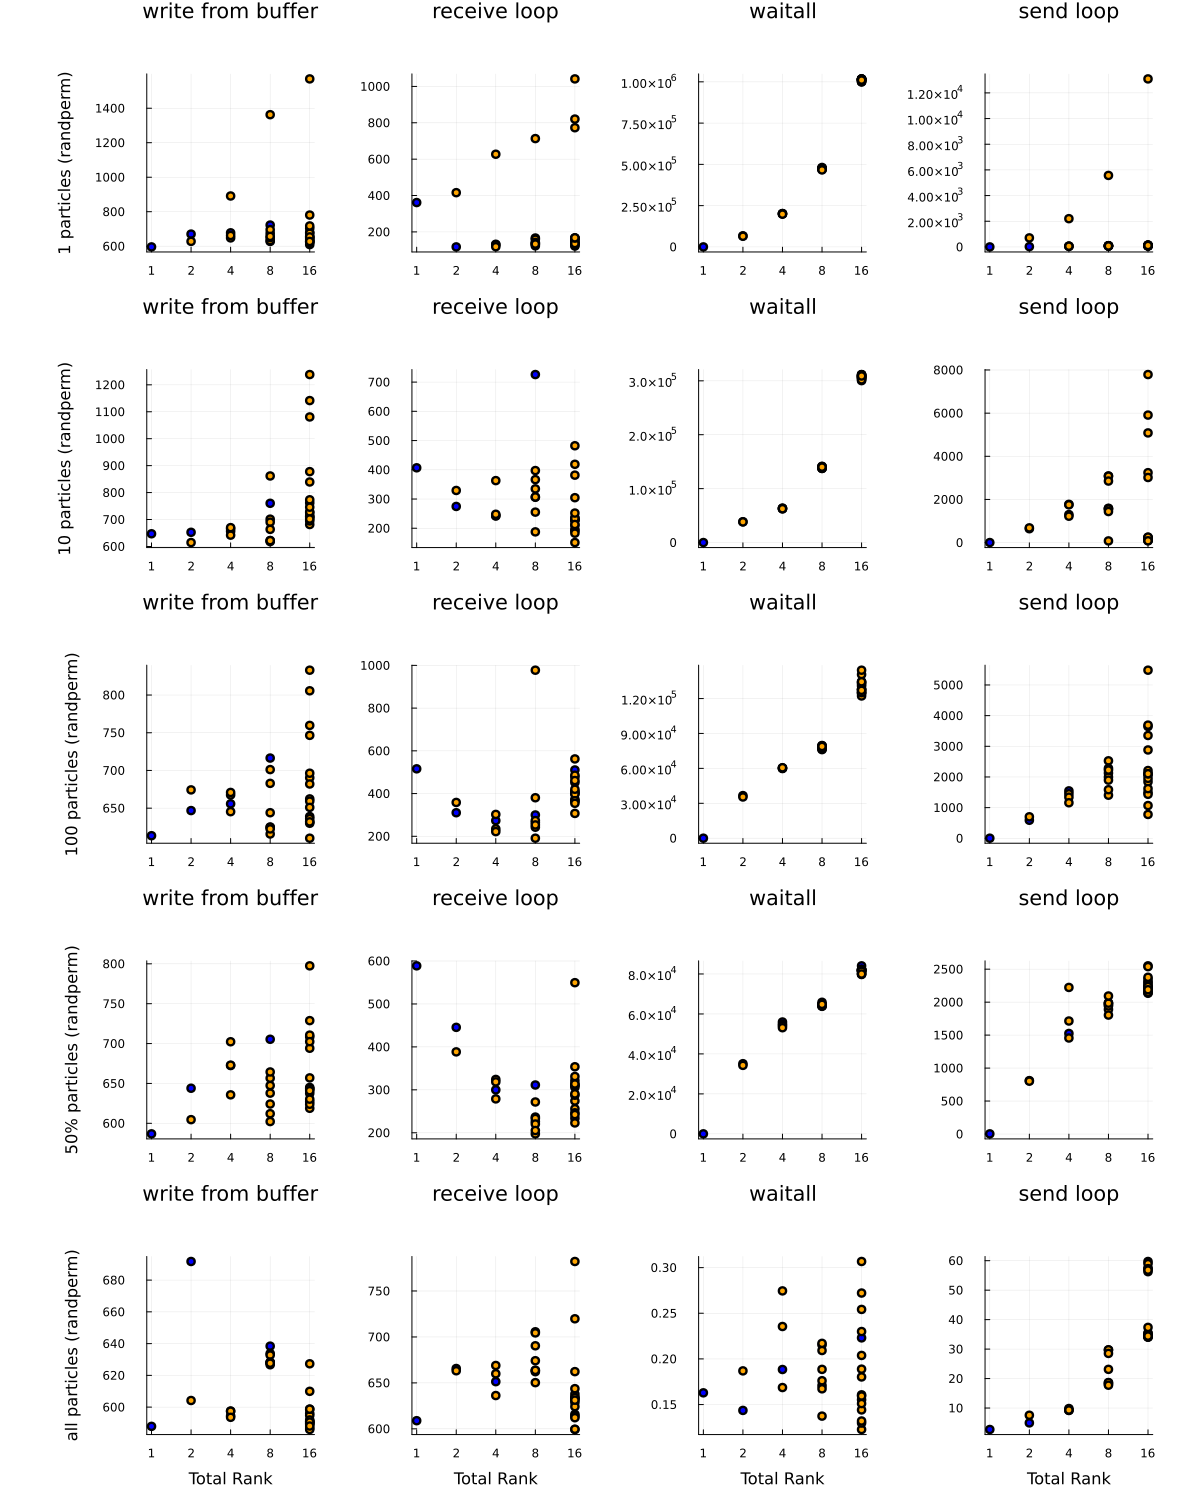

In [60]:
function render(df, label=false)
  trials = unique(df.trial)
  ops    = unique(df.op)

  ntrials, nops = length(trials), length(ops)

  # 2) Create an empty grid, with row & column titles
  plt = plot(
    layout     = (ntrials, nops),
    legend = label ? :topleft : :none,
    size       = (300 * nops, 300 * ntrials),
  )

  # 3) Fill it in
  for (i, trial) in enumerate(trials)
    for (j, op) in enumerate(ops)
      sub = df[(df.trial .== trial) .& (df.op .== op), :]
      for rk in unique(sub.rank)
        subrk = sub[sub.rank .== rk, :]
        scatter!(
          plt[i, j],
          string.(subrk.total_rank),    # categorical x
          subrk.time_micros;
          marker     = :circle,
          markersize = 4,
          label      = rk,
          right_margin = 10mm,
          color      = rk == "0" ? :blue : :orange,
        )
      end
      plot!(plt[i, j], title = string(op), top_margin = 10mm)
      if j == 1
        plot!(plt[i, j], ylabel = string(trial), left_margin = 20mm)
      end

      # only the bottom row gets the shared x‐axis label
      if i == ntrials
        plot!(plt[i, j], xlabel = "Total Rank")
      end
    end
  end

  display(plt)
end
render(first_df)
render(rand_df)